# Hands-on 01: Online retail - KMeans

## Concepts

## Clustering

> The tasks of combining RFM Scores could become very complex (with increasing numbers of combinations). Especially when, we need to combine them in the way that we can have meaningful segments to take action. Machine Learning techniques come to place. 


- Input any customer features we have, and find out different clusters can be obtained from the data
- The process is by Machine Learning (`Unsupervised`). We can find traits of customer segments by analyzing the characteristics of the clusters
- Clustering could applied with R, F, M as inputs, or it could take more attributes of information about the customers
- Clustering is especially useful when many customer attributes, that make the combination of all possible segments is high, and the problem becomes complex

> Discussion: How is a good customer segmentation?


### K-means Algorithms
> Among numerous other clustering algorithms, we introduce the k-means clustering algorithms.

- K-means algorithms splits the records in the data into a pre-defined number of clusters (`k`)
	- Data points within a cluster are "close" to each others -> Similar
- How? 
	- Find the centroid (`mean`) of clusters
	- Minimize the distance between data points and the centroid within the clusters
- Need to decide `k` beforehand?
	- Back to the question: How we define a good segmentation/clustering?
		- How close the data points within the same cluter, compare to the distance with other clusters
		- Measure by `Silhouette Coefficient` (S-coef)
			- Range from `-1` to `1`
			- Closer to `1` -> Better
		- Measure by Total Distance - `Total Within Sum of Square`: distance between data points and the centroid within the cluster
	- `Elbow Method`: We try different value of `k` and plot the metrics of performance (Total Distance of S-coef), graphically define the Elbow Points -> Optional `k`
	- Though sometimes, due to business acumen or practical reasons of execution, we will choose a desired `k` (for example, by method, k=10 is optimal, but execute 10 segments are not practical for business, we might choose 5-6 segments)

In [ ]:
!pip install squarify

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns 
import pandas as pd 
import missingno
from sklearn.cluster import KMeans ## The libary to run clustering
import squarify # pip install squarify

In [2]:
# OPTIONA:
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [3]:
df = pd.read_excel('data/Online Retail.xlsx', dtype={'CustomerID': str})

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [5]:
# Create the order_value
df['order_value'] = df.Quantity * df.UnitPrice 

## Data Explore

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
 8   order_value  541909 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 37.2+ MB


### Missing Values


Preview of data with null values:
     InvoiceNo StockCode                      Description  Quantity  \
622     536414     22139                              NaN        56   
1443    536544     21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444    536544     21774  DECORATIVE CATS BATHROOM BOTTLE         2   

             InvoiceDate  UnitPrice CustomerID         Country  order_value  
622  2010-12-01 11:52:00       0.00        NaN  United Kingdom         0.00  
1443 2010-12-01 14:32:00       2.51        NaN  United Kingdom         2.51  
1444 2010-12-01 14:32:00       2.51        NaN  United Kingdom         5.02  
(135080, 9)


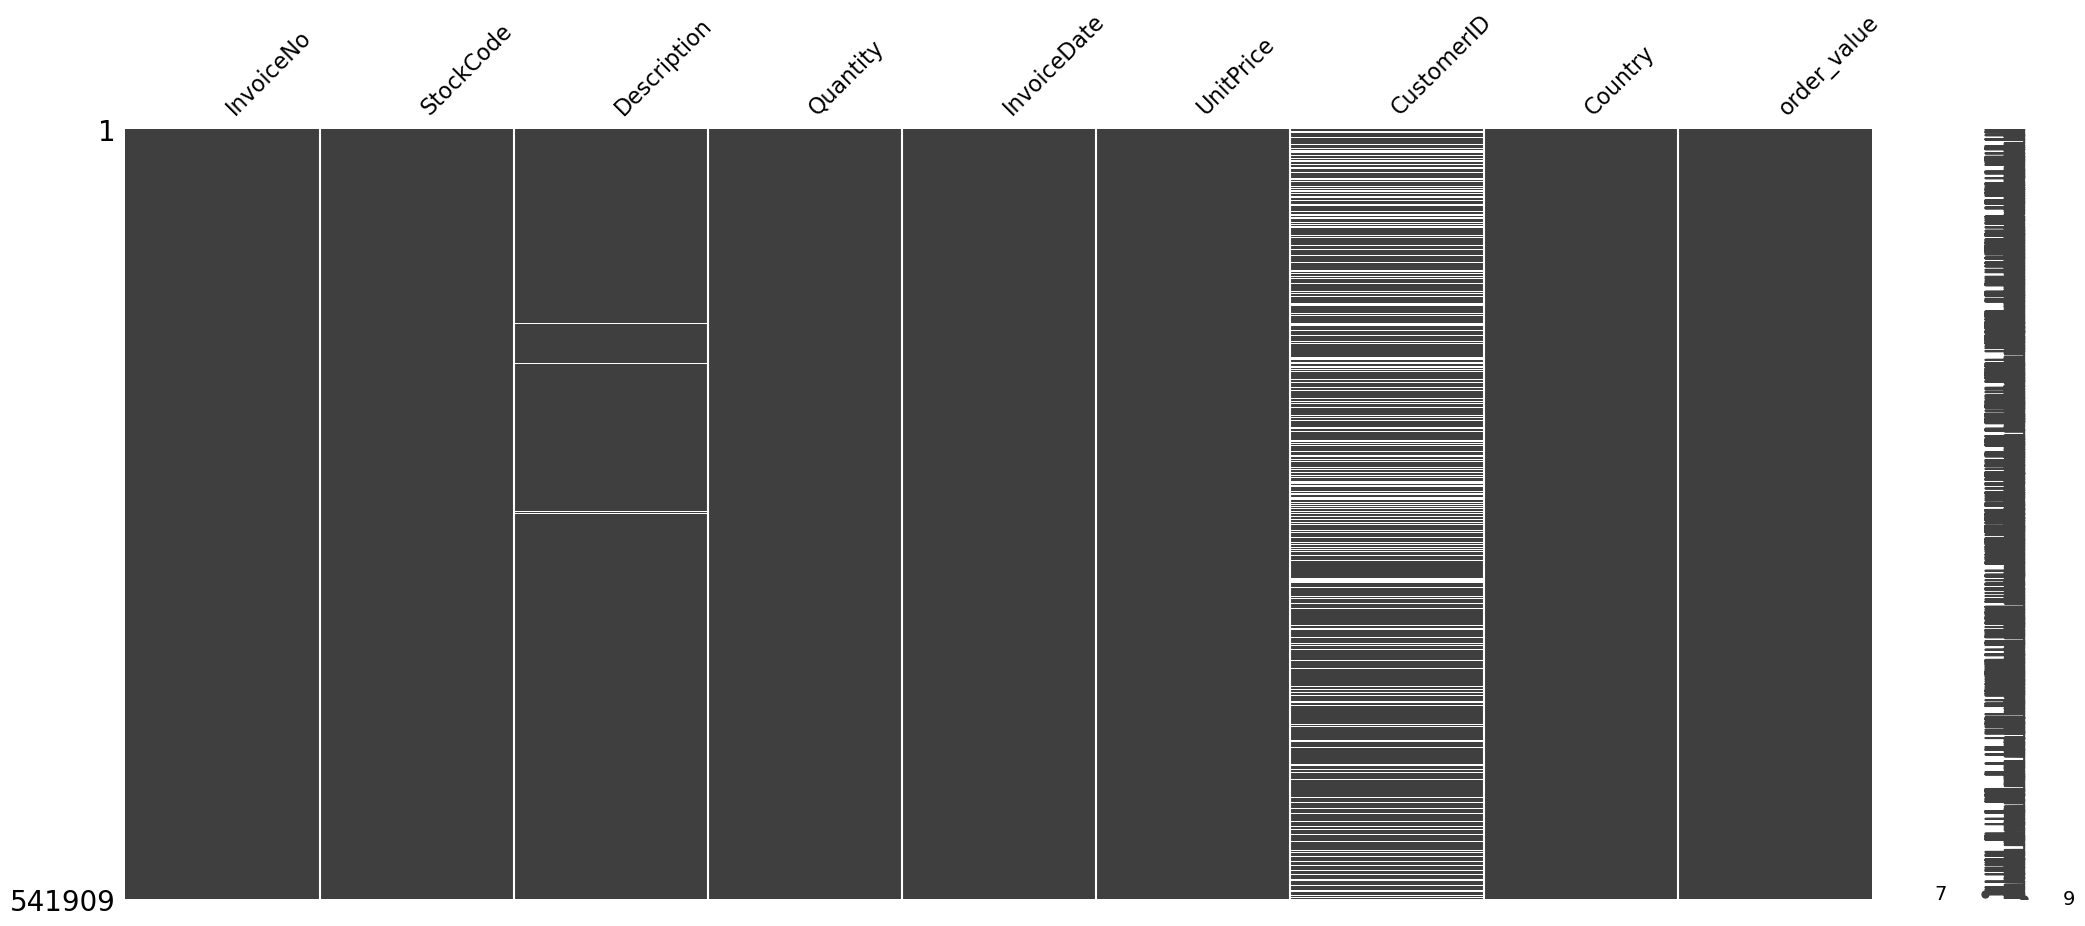

In [7]:
## generate preview of entries with null values
print("\nPreview of data with null values:")
print('='*10)
print(df[df.isnull().any(axis=1)].head(3))
print(df[df.isnull().any(axis=1)].shape)
missingno.matrix(df)
plt.show()

In [8]:
# drop na
df1 = df.dropna()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      406829 non-null  object        
 8   order_value  406829 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 31.0+ MB


### Outliers

In [9]:
df1.describe([0.01,0.05,0.25,0.50, 0.75, 0.90,0.95,0.99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,90%,95%,99%,max
Quantity,406829.0,12.061303,248.693370,-80995.0,-2.00,1.00,2.00,5.00,12.00,24.00,36.0,120.00,80995.0
UnitPrice,406829.0,3.460471,69.315162,0.0,0.21,0.42,1.25,1.95,3.75,6.75,8.5,15.00,38970.0
order_value,406829.0,20.401854,427.591718,-168469.6,-9.90,0.85,4.20,11.10,19.50,35.40,67.2,199.68,168469.6


In [10]:
# Negative values are returned items.
df1 = df1[df1.Quantity >= 0]
df1.describe([0.01,0.05,0.25,0.50, 0.75, 0.90,0.95,0.99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,90%,95%,99%,max
Quantity,397924.0,13.021823,180.420210,1.0,1.00,1.00,2.00,6.00,12.00,24.00,36.0,120.00,80995.00
UnitPrice,397924.0,3.116174,22.096788,0.0,0.21,0.42,1.25,1.95,3.75,6.35,8.5,14.95,8142.75
order_value,397924.0,22.394749,309.055588,0.0,0.55,1.25,4.68,11.80,19.80,35.40,67.5,202.50,168469.60


In [11]:
df1 = df1[(df1.Quantity < 36) & (df1.order_value < 100)]
df1.describe([0.01,0.05,0.25,0.50, 0.75, 0.90,0.95,0.99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,90%,95%,99%,max
Quantity,372046.0,7.103326,6.825913,1.0,1.00,1.00,2.00,4.00,12.00,16.00,24.0,25.00,35.00
UnitPrice,372046.0,2.936540,3.255008,0.0,0.29,0.42,1.25,1.95,3.75,6.75,8.5,14.95,85.58
order_value,372046.0,13.579193,13.188773,0.0,0.55,1.25,4.20,10.20,17.70,27.04,37.2,70.80,99.90


## Per-customer Metrics
- We can reuse the R, F, M Scores (same scale 1-5) as input for clustering (convert from categorical to numerical 1-5)
- Here we will calculate some others user-level metrics, to demonstrate for general approach of K-means

`TODO_01`: Do we have any hypothesis about how these three metrics: `TotalValue`, `OrderCnt`, `UniqueProduct` will clustering our customers?

~> Your comment

In [12]:
customer_df = df1.groupby('CustomerID').agg({
    'order_value': sum,
    'InvoiceNo': lambda x: x.nunique(),
    'Description': lambda x: x.nunique()
})

customer_df.columns = ['TotalValue','OrderCnt','UniqueProduct']
customer_df['Avg_OrderValue'] = customer_df['TotalValue']/customer_df['OrderCnt']
# NOTE: Add any further user-level metrics that you think helpful for the Segmentation tasks (Remember to ask yourself: WHY it is important)
customer_df.head()

,TotalValue,OrderCnt,UniqueProduct,Avg_OrderValue
CustomerID,,,,
12347,3681.08,7,100,525.868571
12348,210.20,4,7,52.550000
12349,1367.55,1,70,1367.550000
12350,334.40,1,17,334.400000
12352,1665.74,7,58,237.962857


In [13]:
customer_df.describe().T

,count,mean,std,min,25%,50%,75%,max
TotalValue,4221.0,1196.892796,2652.552688,0.0,243.5600,565.61,1321.7300,108039.18
OrderCnt,4221.0,4.066809,7.153648,1.0,1.0000,2.00,4.0000,203.00
UniqueProduct,4221.0,60.649372,83.673119,1.0,16.0000,35.00,76.0000,1746.00
Avg_OrderValue,4221.0,290.182053,242.770327,0.0,148.2425,236.30,357.9825,4172.07


## Normalize the different-scale metrics
- K-means clustering is based on distance (to determine the similarity), so this algorithms is sensitive to scales of metrics
- On the above summary table, we notice that each metrics has different scale

=> We need to normalize so they have the same scale.

There are many different way to do, but we will apply the two-step approach:

1. Rank metrics so each customer get the rank value from 1 to N = 4221 (total customers) => This is to remove any possible outliers
2. Normalize it by center around mean, and normalize by standard deviation => Each series will have mean of 0 and std = 1


In [14]:
# Step 1: Rank
rank_df = customer_df.rank(method='first')
rank_df.head()

,TotalValue,OrderCnt,UniqueProduct,Avg_OrderValue
CustomerID,,,,
12347,3958.0,3569.0,3482.0,3809.0
12348,892.0,2797.0,385.0,158.0
12349,3204.0,1.0,3057.0,4198.0
12350,1445.0,2.0,1104.0,2986.0
12352,3402.0,3570.0,2806.0,2129.0


In [15]:
rank_df.describe().T

,count,mean,std,min,25%,50%,75%,max
TotalValue,4221.0,2111.0,1218.642072,1.0,1056.0,2111.0,3166.0,4221.0
OrderCnt,4221.0,2111.0,1218.642072,1.0,1056.0,2111.0,3166.0,4221.0
UniqueProduct,4221.0,2111.0,1218.642072,1.0,1056.0,2111.0,3166.0,4221.0
Avg_OrderValue,4221.0,2111.0,1218.642072,1.0,1056.0,2111.0,3166.0,4221.0


In [16]:
# Step 2: Normalize
normalized_df = (rank_df - rank_df.mean()) / rank_df.std()
normalized_df.head()

,TotalValue,OrderCnt,UniqueProduct,Avg_OrderValue
CustomerID,,,,
12347,1.515621,1.196414,1.125023,1.393354
12348,-1.000294,0.562922,-1.416331,-1.602603
12349,0.896900,-1.731435,0.776274,1.712562
12350,-0.546510,-1.730615,-0.826330,0.718012
12352,1.059376,1.197234,0.570307,0.014771


In [17]:
# Value center around 0 (50%), and have the std = 1
normalized_df.describe().T

,count,mean,std,min,25%,50%,75%,max
TotalValue,4221.0,3.385115e-17,1.0,-1.731435,-0.865718,0.0,0.865718,1.731435
OrderCnt,4221.0,1.596554e-17,1.0,-1.731435,-0.865718,0.0,0.865718,1.731435
UniqueProduct,4221.0,-3.081323e-17,1.0,-1.731435,-0.865718,0.0,0.865718,1.731435
Avg_OrderValue,4221.0,1.457151e-17,1.0,-1.731435,-0.865718,0.0,0.865718,1.731435


## k-means clustering

Here we desire to create # clusters. Normally:


- Number of clusters come from business acument
- Data-driven way: Elbow methods

In [18]:
## Choose k=4
kmeans = KMeans(n_clusters=4).fit(normalized_df[['TotalValue', 'OrderCnt', 'UniqueProduct', 'Avg_OrderValue']])

In [19]:
four_cluster_df = normalized_df[['TotalValue', 'OrderCnt', 'UniqueProduct', 'Avg_OrderValue']].copy(deep=True)
four_cluster_df['Cluster'] = kmeans.labels_
four_cluster_df.head()

,TotalValue,OrderCnt,UniqueProduct,Avg_OrderValue,Cluster
CustomerID,,,,,
12347,1.515621,1.196414,1.125023,1.393354,1
12348,-1.000294,0.562922,-1.416331,-1.602603,3
12349,0.896900,-1.731435,0.776274,1.712562,0
12350,-0.546510,-1.730615,-0.826330,0.718012,0
12352,1.059376,1.197234,0.570307,0.014771,1


In [20]:
four_cluster_df.Cluster.value_counts()

1    1199
3    1164
0     984
2     874
Name: Cluster, dtype: int64

### Scatter Plots: Behaviors on Clusters

Now, let's deep-dive in each cluster output of the Kmeans and analyze their characteristics.

In [21]:
## Plot
def cluster_plot(x='OrderCnt', y='TotalValue'):
  plt.scatter(
      four_cluster_df.loc[four_cluster_df['Cluster'] == 0][x], 
      four_cluster_df.loc[four_cluster_df['Cluster'] == 0][y],
      c='blue'
  )

  plt.scatter(
      four_cluster_df.loc[four_cluster_df['Cluster'] == 1][x], 
      four_cluster_df.loc[four_cluster_df['Cluster'] == 1][y],
      c='red'
  )

  plt.scatter(
      four_cluster_df.loc[four_cluster_df['Cluster'] == 2][x], 
      four_cluster_df.loc[four_cluster_df['Cluster'] == 2][y],
      c='orange'
  )

  plt.scatter(
      four_cluster_df.loc[four_cluster_df['Cluster'] == 3][x], 
      four_cluster_df.loc[four_cluster_df['Cluster'] == 3][y],
      c='green'
  )

  plt.title('{} vs. {}'.format(y,x))
  plt.xlabel(x)
  plt.ylabel(y)

  plt.grid()
  plt.show()

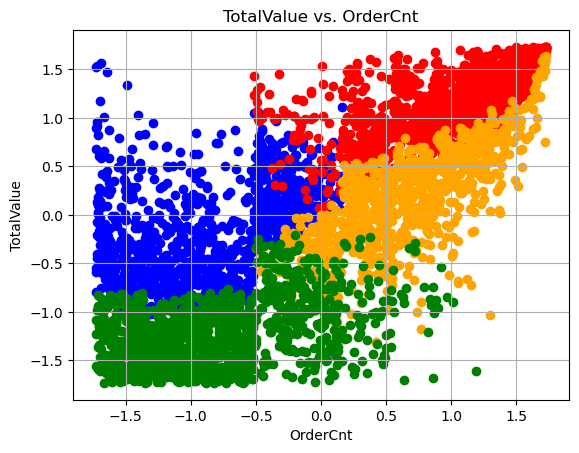

In [22]:
cluster_plot(x='OrderCnt', y='TotalValue')

`TODO_02`: From the scatter plot above, comments

~> Your comments

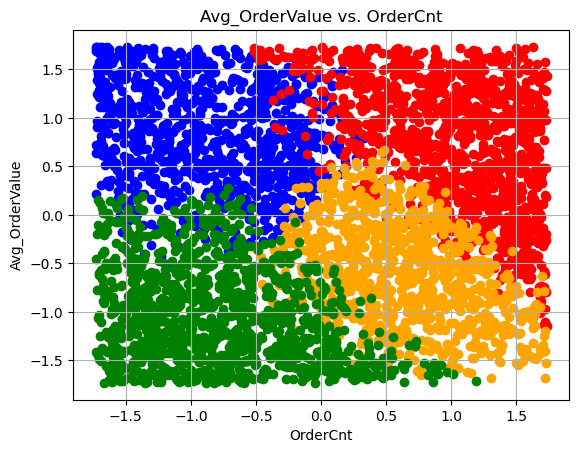

In [23]:
cluster_plot(x='OrderCnt', y='Avg_OrderValue')

`TODO_03`: From the scatter plot above, comments

~> Your comments

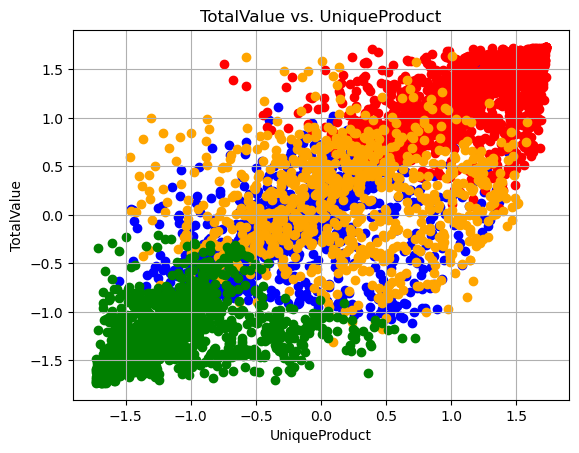

In [24]:
cluster_plot(x='UniqueProduct', y='TotalValue')

`TODO_04`: From the scatter plot above, comments

~> Your comments

## Segment Analysis

<AxesSubplot:xlabel='Cluster', ylabel='TotalValue'>

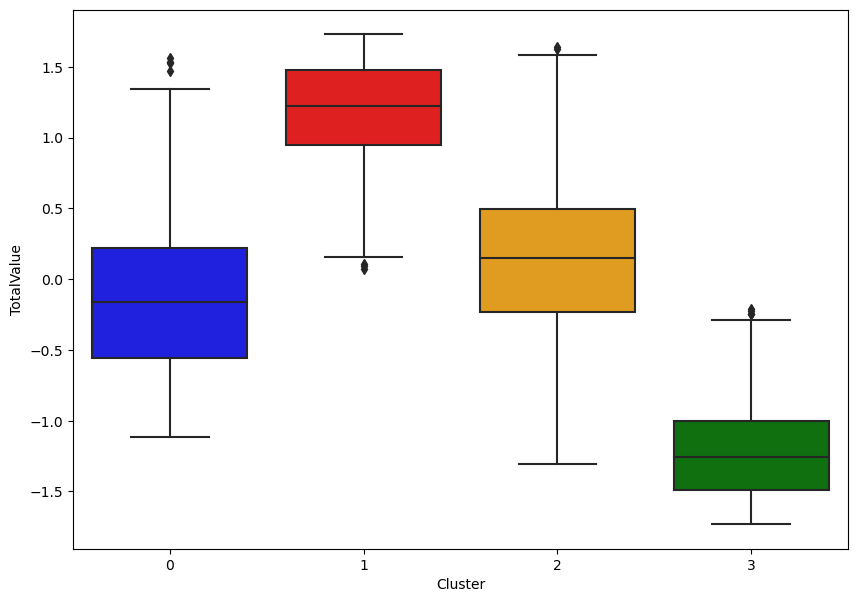

In [25]:
# We can also implement the boxplot or any analysis (as in RFM lab) with the cluster
plt.figure(figsize=(10, 7))
colors = {0:'blue',1:'red',2:'orange',3:'green'}
sns.boxplot(x='Cluster', y='TotalValue', palette=colors, data=four_cluster_df)

`TODO_05`: From the Scatter Plots, igure out characteristics of 4 groups

~> Your comment

### What they buys?

`TODO_06`: From the results below, provide any meaningful insights for business

~> Your comment

In [26]:
# Red
four_cluster_df[four_cluster_df.Cluster==1].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1199 entries, 12347 to 18287
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TotalValue      1199 non-null   float64
 1   OrderCnt        1199 non-null   float64
 2   UniqueProduct   1199 non-null   float64
 3   Avg_OrderValue  1199 non-null   float64
 4   Cluster         1199 non-null   int32  
dtypes: float64(4), int32(1)
memory usage: 51.5+ KB


In [27]:
merged_df1 = pd.merge(df1, four_cluster_df['Cluster'].reset_index())
merged_df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_value,Cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2


In [28]:
# Red: Top10 products
(merged_df1[merged_df1.Cluster == 1]
.groupby('Description')
.agg({'InvoiceNo': 'count','UnitPrice': 'mean','Quantity':'mean'})
.sort_values('InvoiceNo', ascending=False)
.rename(columns={'InvoiceNo':'order_cnt','Quantity':'quantity_per_order'})).head(10)

,order_cnt,UnitPrice,quantity_per_order
Description,,,
WHITE HANGING HEART T-LIGHT HOLDER,1305,2.913801,9.932567
JUMBO BAG RED RETROSPOT,1098,2.059872,9.981785
LUNCH BAG RED RETROSPOT,1040,1.673846,8.777885
REGENCY CAKESTAND 3 TIER,900,12.869500,2.544444
PARTY BUNTING,875,4.946423,5.363429
LUNCH BAG BLACK SKULL.,861,1.649768,7.527294
ASSORTED COLOUR BIRD ORNAMENT,826,1.690000,13.828087
SET OF 3 CAKE TINS PANTRY DESIGN,801,4.997640,3.401998
LUNCH BAG SPACEBOY DESIGN,794,1.662242,7.560453


In [29]:
# Orange: Top10 products
(merged_df1[merged_df1.Cluster == 2]
.groupby('Description')
.agg({'InvoiceNo': 'count','UnitPrice': 'mean','Quantity':'mean'})
.sort_values('InvoiceNo', ascending=False)
.rename(columns={'InvoiceNo':'order_cnt','Quantity':'quantity_per_order'})).head(10)

,order_cnt,UnitPrice,quantity_per_order
Description,,,
WHITE HANGING HEART T-LIGHT HOLDER,346,2.886416,8.586705
REX CASH+CARRY JUMBO SHOPPER,288,0.950000,2.003472
ASSORTED COLOUR BIRD ORNAMENT,219,1.690000,11.461187
REGENCY CAKESTAND 3 TIER,205,12.741220,1.975610
PARTY BUNTING,190,4.935789,5.189474
POSTAGE,174,20.232586,1.505747
NATURAL SLATE HEART CHALKBOARD,169,2.950000,6.408284
HEART OF WICKER SMALL,161,1.650000,7.670807
JUMBO BAG RED RETROSPOT,157,2.037962,9.484076


In [30]:
# TODO_07: Change the number of cluster, till you have the results and insights that interesting to share